<a href="https://colab.research.google.com/github/lucas-fpaiva/tcc_pes/blob/main/piloto/notebookraul_Piloto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendendo o problema de predição de saude da aeronave

Objetivos:

* Separar duas aeronaves para o teste final 
* Selecionar duas das séries para analisar dentro das aeronaves de treino
* Visualizar e realizar o preprocessamento dos dados
* Aplicar um modelo de predição usando uma para treinar e outra para testar

In [58]:
print("Estou rodando no Colab (S/N)?")
ambiente = input()
ambiente=ambiente.upper()

if ambiente == "S":
  from google.colab import drive
  import os

  drive.mount('/content/drive',force_remount=True)
  os.chdir('/content/drive/Shareddrives/TCC_PES/codigos/Piloto')

Estou rodando no Colab (S/N)?
S
Mounted at /content/drive


## Tratamento e organização inicial dos dados

In [51]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import plotly as py
import matplotlib.gridspec as gridspec

from sklearn.metrics import mean_squared_error

### Importação dos dados

In [52]:
#importando direto do github
data_feat = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/caracteristica.csv')
data_health = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/saude.csv')

### Separação de duas aeronaves para o teste final

In [53]:
np.random.seed(123)
np.random.randint(0,2,10)
teste = np.random.choice(np.unique(data_health.COD_AENV),2)
print("Aviões usados para teste: ", teste)

data_health  = data_health[data_health.COD_AENV != teste[0]][data_health.COD_AENV != teste[1]]

data_feat = data_feat[data_feat.COD_AENV != teste[0]][data_feat.COD_AENV != teste[1]]

print("Aviões usados para teste: ", np.unique(data_health.COD_AENV))


Aviões usados para teste:  [9834 9747]
Aviões usados para teste:  [1011 9486 9526 9636 9664 9678 9770 9793]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



### Calculo da mediana do desgaste e do valor da caracteristica por dia

União dos dois datasets

In [54]:
data_health = data_health.groupby(by=['COD_FALH','COD_AENV','DT_PROC']).median().reset_index()
data_feat = data_feat.groupby(by=['COD_FALH','COD_AENV','COD_EVNT']).median().reset_index()


data_health['id']=data_health.index
data_health.head()
data = pd.merge(data_feat, data_health, on=['COD_EVNT','COD_FALH','COD_AENV']).sort_values('DT_PROC')
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:1218: UserWarning:

You are merging on int and float columns where the float values are not equal to their int representation



,COD_FALH,COD_AENV,COD_EVNT,COD_CARAC_NOM,VLR_CARAC,DT_PROC,VLR_DESG,id
3471,23,1011,116846,72.0,0.809445,2010-01-11,56.136860,6702
10389,35,1011,116846,63.0,0.000000,2010-01-11,4.396998,20114
6929,24,1011,116846,72.0,0.418330,2010-01-11,56.621538,13408
9906,24,9793,116311,72.0,0.000000,2010-01-11,60.415650,19291
6447,23,9793,116311,72.0,0.539028,2010-01-11,66.982252,12585


### Vizualização das séries

In [55]:
# Visualizando a Falha 23
px.line(data[data.COD_FALH==23], x='DT_PROC', y='VLR_DESG', color='COD_AENV')

In [56]:
# Visualizando a Falha 35
px.line(data[data.COD_FALH==35], x='DT_PROC', y='VLR_DESG', color='COD_AENV')

In [57]:
px.line(data[data.COD_FALH==35], x='DT_PROC', y='VLR_CARAC', color='COD_AENV')

## Projeto piloto com duas aeronaves

### Selecionando as aeronaves 1011 e 9486 com falha 35 para treino e teste, respectivamente

In [ ]:
f35_treino = data[(data.COD_AENV==1011) & (data.COD_FALH==35)]
f35_teste = data[(data.COD_AENV==9486)  & (data.COD_FALH==35)]

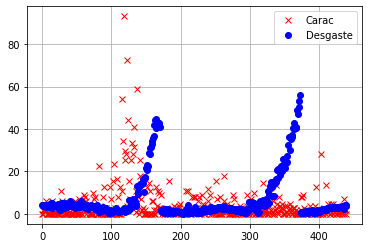

In [ ]:
# Vizualizando a Falha 35 desgaste e caracteristica
desgaste = f35_treino.VLR_DESG.values
carac = f35_treino.VLR_CARAC.values
plt.plot(carac,'xr',label='Carac')
plt.plot(desgaste,'ob',label='Desgaste')
plt.legend()
plt.grid()
#plt.savefig("img.pdf")


### Preparação dos dados para treino do modelo

* Identificação quebras na série
* Divisão da série em trechos úteis 
* Janelamento dos trechos em entradas e saídas

In [ ]:
def xyfunc (desgaste):
  trechos = []
  for i in range(0,len(desgaste)-1):
    if desgaste[i]-desgaste[i+1]>10:
      trechos.append(desgaste[i-30:i])
      
  trechos.append(desgaste[-30:])
  trechos = np.array(trechos)
  trechos.shape
  x = trechos[:,0:20]
  y = trechos[:,-1]
  return x, y

In [ ]:
desgaste_train = f35_treino.VLR_DESG.values
x_train, y_train = xyfunc(desgaste_train)

desgaste_test = f35_teste.VLR_DESG.values
x_test, y_test = xyfunc(desgaste_test)

NameError: ignored

### Avaliação de modelos

#### MLP

In [ ]:
#MLPRegressor
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor()

MLP.fit(x_train,y_train)
y_pred = MLP.predict(x_test)


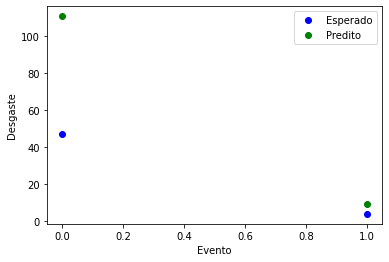

In [ ]:
plt.plot(y_test, "ob", label = "Esperado")
plt.plot(y_pred, "og", label = "Predito")
plt.xlabel("Evento")
plt.ylabel("Desgaste")
plt.legend()

#### SVM

#### RNN

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0],1, x_train[0].shape[0])) #reshape para treinar os modelos recorrentes
x_test = np.reshape(x_test, (x_test.shape[0],1, x_test[0].shape[0])) #reshape para treinar os modelos recorrentes
print(x_train.shape, y_train.shape)

(3, 1, 20) (3,)


In [ ]:
from tensorflow.keras.layers import SimpleRNN as RNN
# from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(RNN(5, input_shape=(1,20)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, verbose=0)

y_pred = model.predict(x_test)

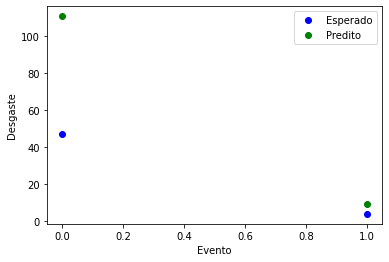

In [ ]:
plt.plot(y_test, "ob", label = "Esperado")
plt.plot(y_pred, "og", label = "Predito")
plt.xlabel("Evento")
plt.ylabel("Desgaste")
plt.legend()

## Projeto piloto com oito aeronaves

In [126]:
def xyfunc1 (desgaste,look_back):
  trechos = []
  n_pontos = look_back+10
  a=0
  for i in range(0,len(desgaste)-1):
    if desgaste[i]-desgaste[i+1]>10:
      if i>=n_pontos: 
        trechos.append(desgaste[i-n_pontos:i])
        a = i
  if len(desgaste)-a>=n_pontos:       
    trechos.append(desgaste[-n_pontos:])
  trechos = np.array(trechos)
  print(trechos.shape)
  x = trechos[:,0:20]
  y = trechos[:,-1]
  return x, y

In [131]:
def xyfunc (desgaste,look_back):
  trechos = []
  des_uti = []
  quebras = []
  n_pontos = look_back+10
  a=0
  for i in range(0,len(desgaste)-1):
    if abs(desgaste[i]-desgaste[i+1])>10:
      if len(desgaste[a:i])>=n_pontos:
        trechos.append(desgaste[i-n_pontos:i])
        des_uti = des_uti + desgaste[a:i+1].tolist()
      else:
        des_uti = des_uti + len(desgaste[a:i+1])*[0]
        #print(a)
      a = i+1
    quebras.append([a,desgaste[a]])
  if len(desgaste[a:])>=n_pontos:
    trechos.append(desgaste[-n_pontos:])
    des_uti = des_uti + desgaste[a:].tolist()
  else:
    des_uti = des_uti + len(desgaste[a:])*[0]
    #print(a)
  trechos = np.array(trechos)
  quebras = np.array(quebras)
  #print(trechos.shape)
  x = trechos[:,0:20]
  y = trechos[:,-1]
  return x, y, quebras, des_uti

In [127]:
def func_plot (desgaste,aeronave,quebras,new_serie):
  plt.figure(figsize=(15, 2),dpi=300)
  #plt.plot(carac,'xr',label='Carac')
  plt.plot(desgaste,'ok',label='Desgaste real', markersize=4)
  plt.plot(new_serie, 'or',label='Desgaste utilizado', markersize=2)
  plt.legend()
  plt.title(aeronave)
  plt.grid()
  plt.ylim([0,80])
  plt.vlines(quebras[:,0], 0, 100)

def resul_plot (y_test,y_pred,aero):
  plt.figure(figsize=(4,4),dpi=100)
  plt.plot(y_test*100, "ob", label = "Esperado")
  plt.plot(y_pred*100, "og", label = "Predito")
  plt.xlabel("Evento")
  plt.ylabel("Desgaste")
  plt.title(aero)
  plt.legend()



In [128]:
def train_test(data, aeronave_test,look_back,cod_falha,aim='train_test'):
  x_train =[]
  y_train =[]
  for aeronave in np.unique(data.COD_AENV):
    aero_data = data[(data.COD_AENV==aeronave)  & (data.COD_FALH==cod_falha)]
    desgaste = aero_data.VLR_DESG.values
    #func_plot (desgaste,aeronave,quebras)
    x, y, quebras, des_uti = xyfunc(desgaste,look_back=look_back)

    if aim == "plot": 
      func_plot (desgaste,aeronave,quebras,des_uti)

    else: 
      if aeronave == aeronave_test:
        x_test, y_test = x.copy(), y.copy()
      else:
        x_train = x_train + x.tolist()
        y_train = y_train + y.tolist()


        # if np.sum(x_train) == -1:
        #   x_train = x.copy()
        #   y_train = y.copy()
        # else:
        #   x_train = np.concatenate((x_train,x),axis=0)
        #   y_train = np.concatenate((y_train,y),axis=0)

  if aim =='train_test':
    return np.array(x_train)/100, np.array(y_train)/100, x_test/100, y_test/100

### Visualizando as quebras

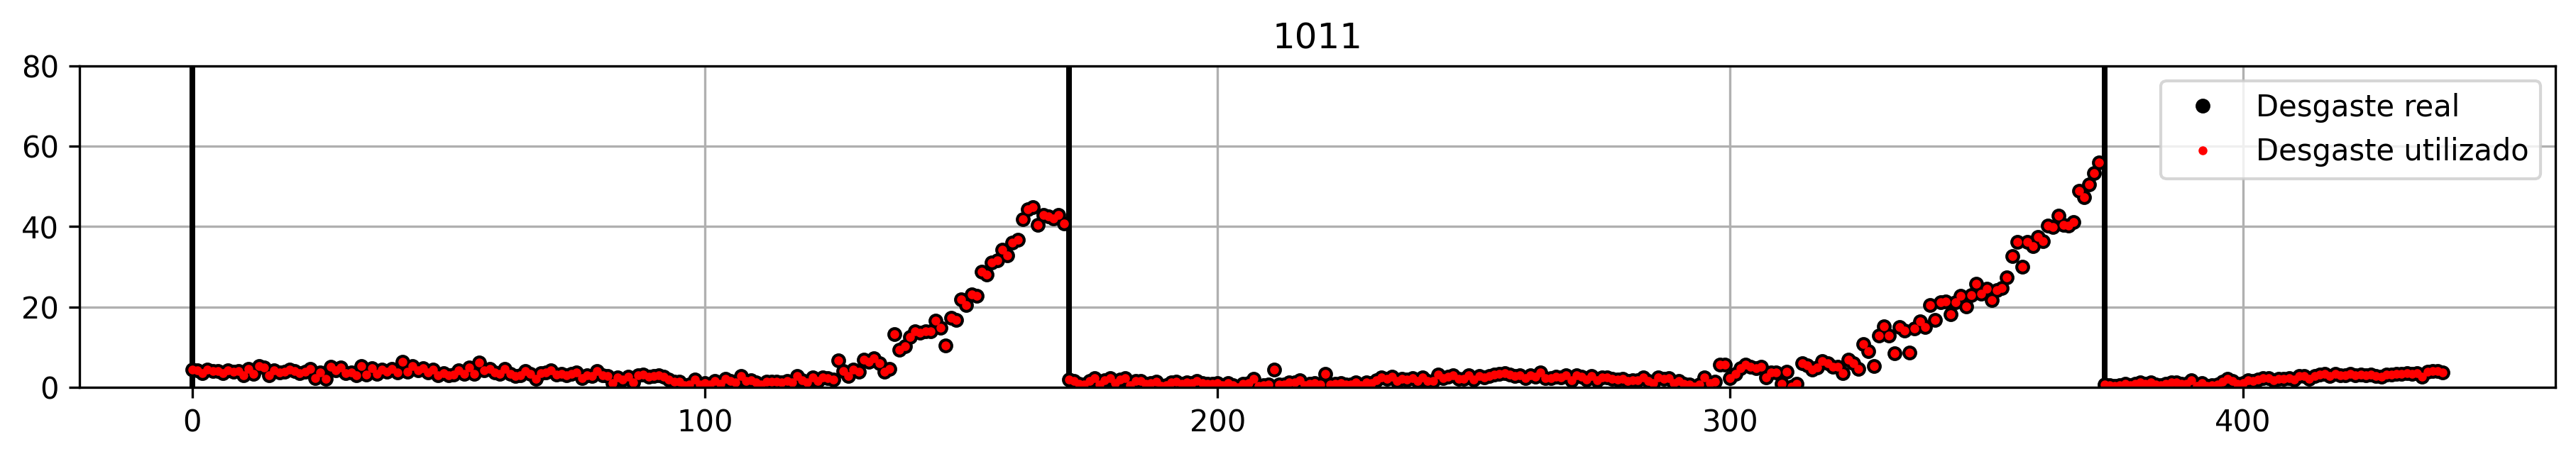

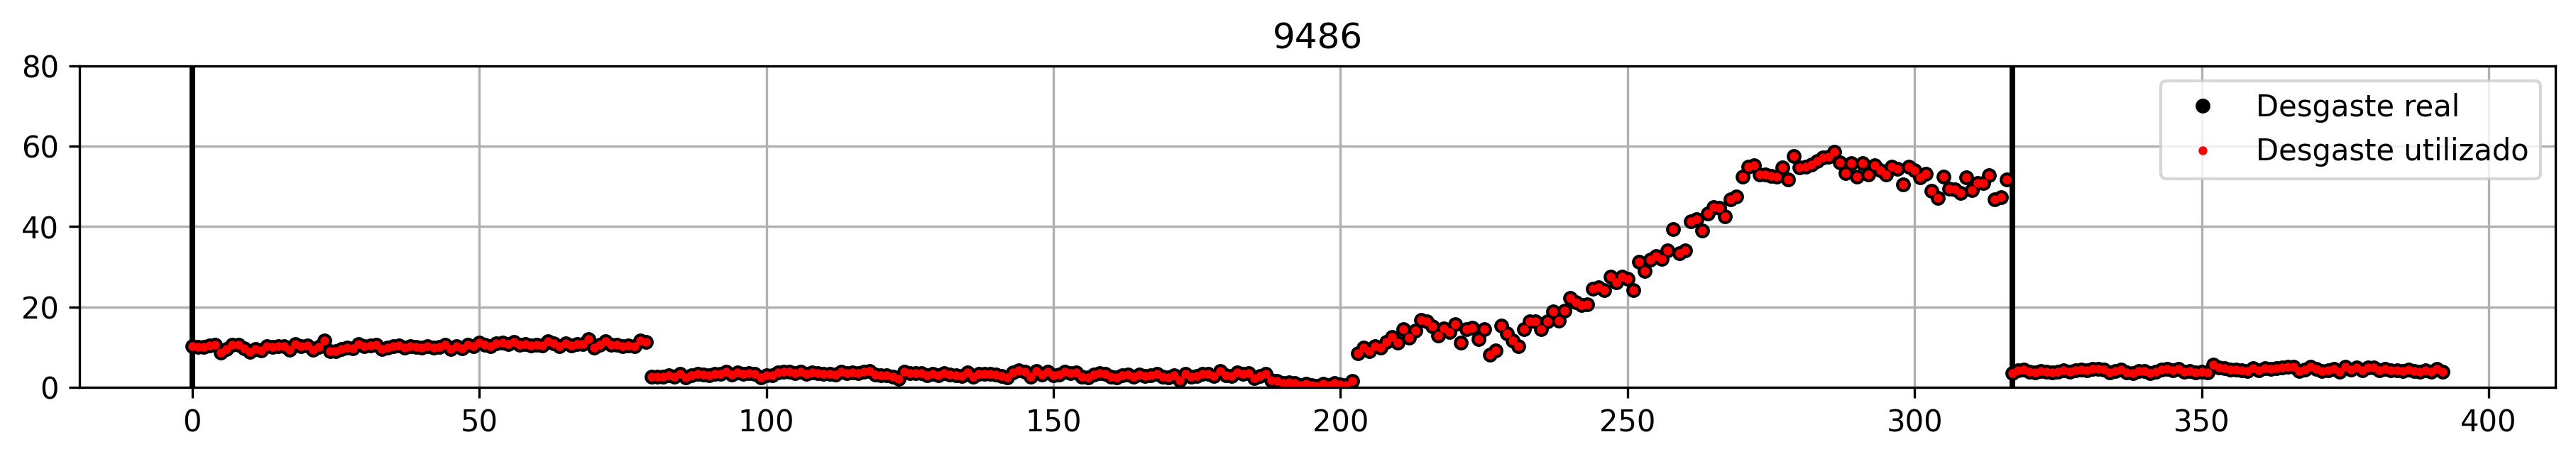

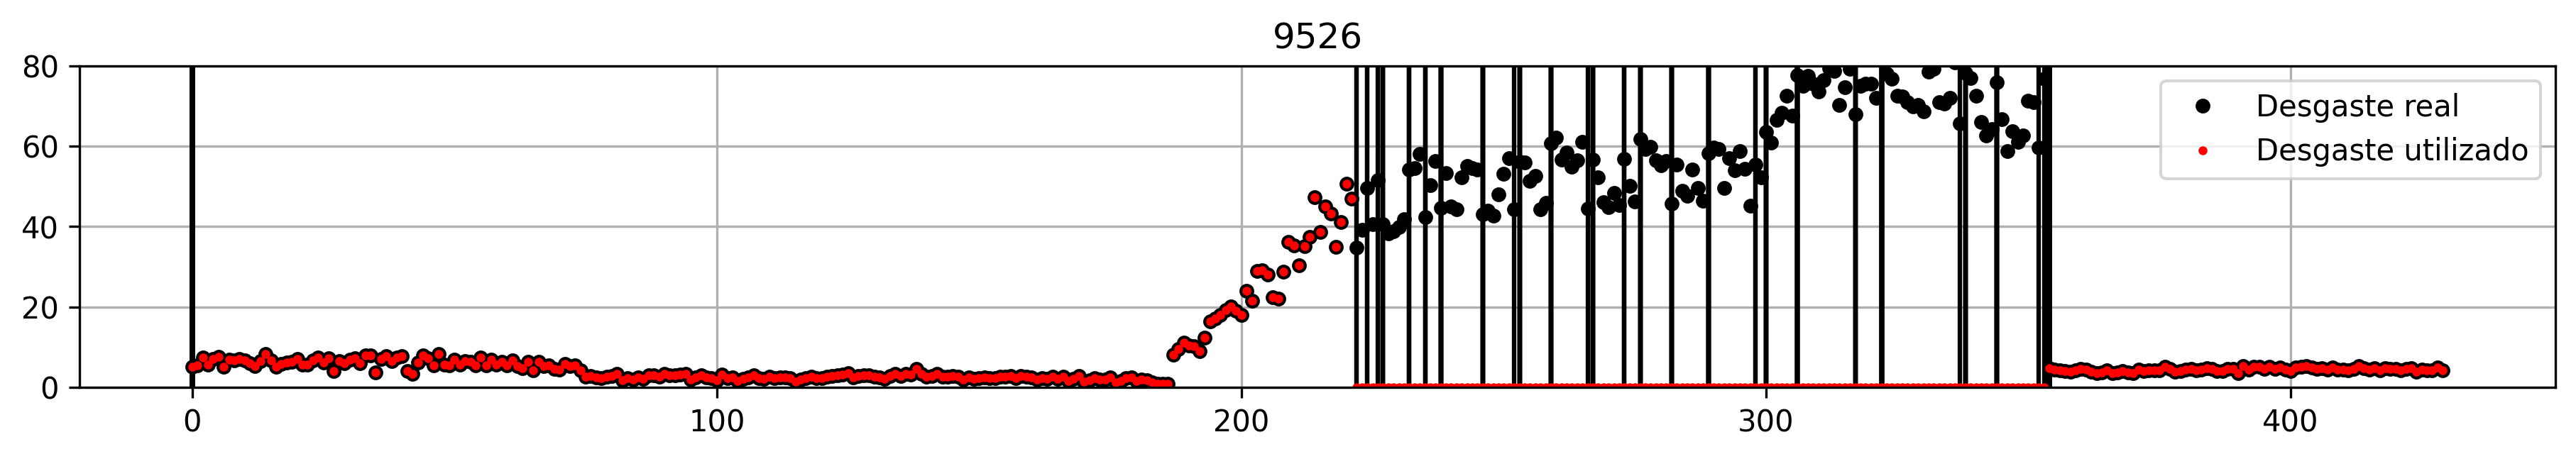

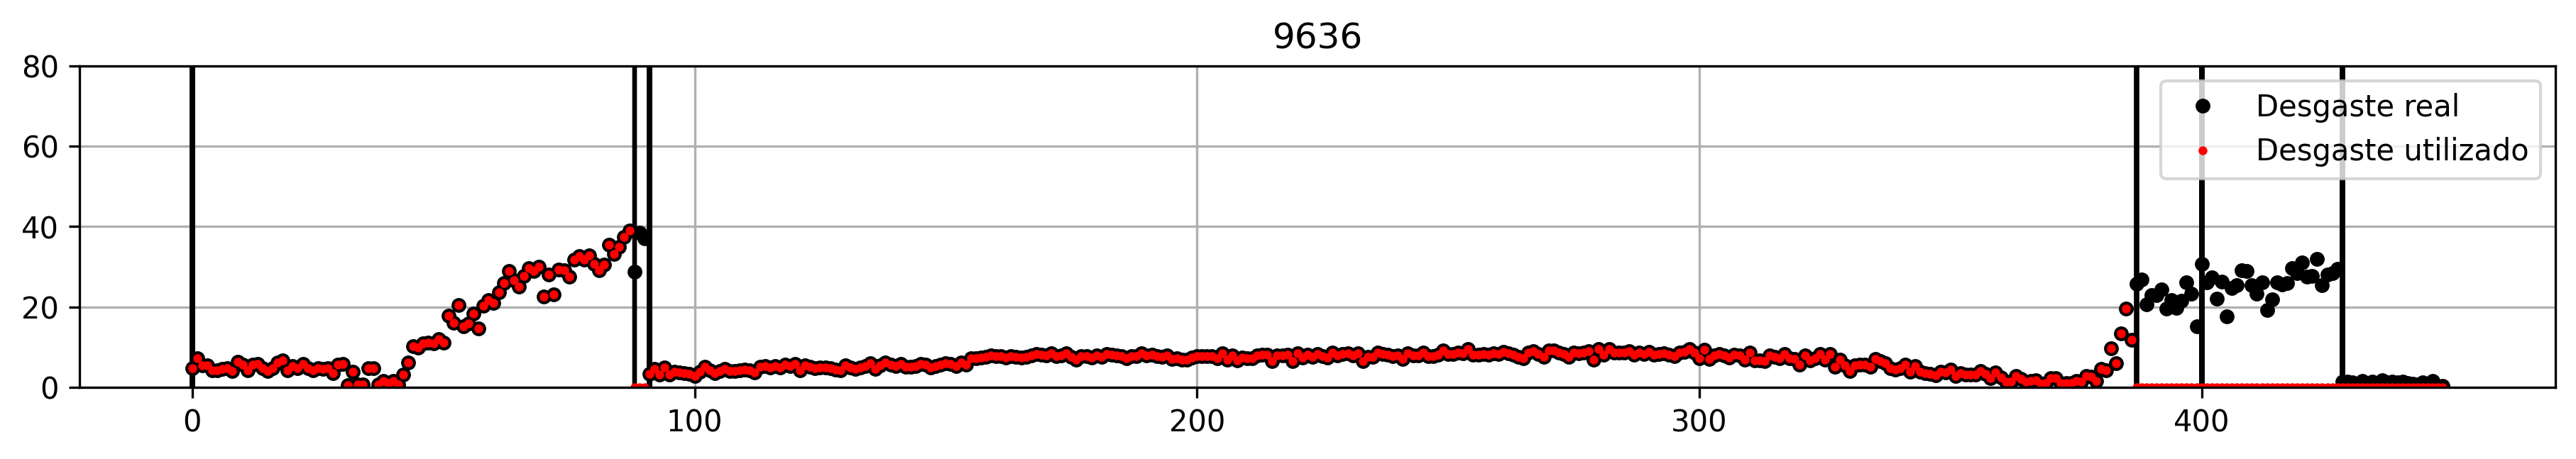

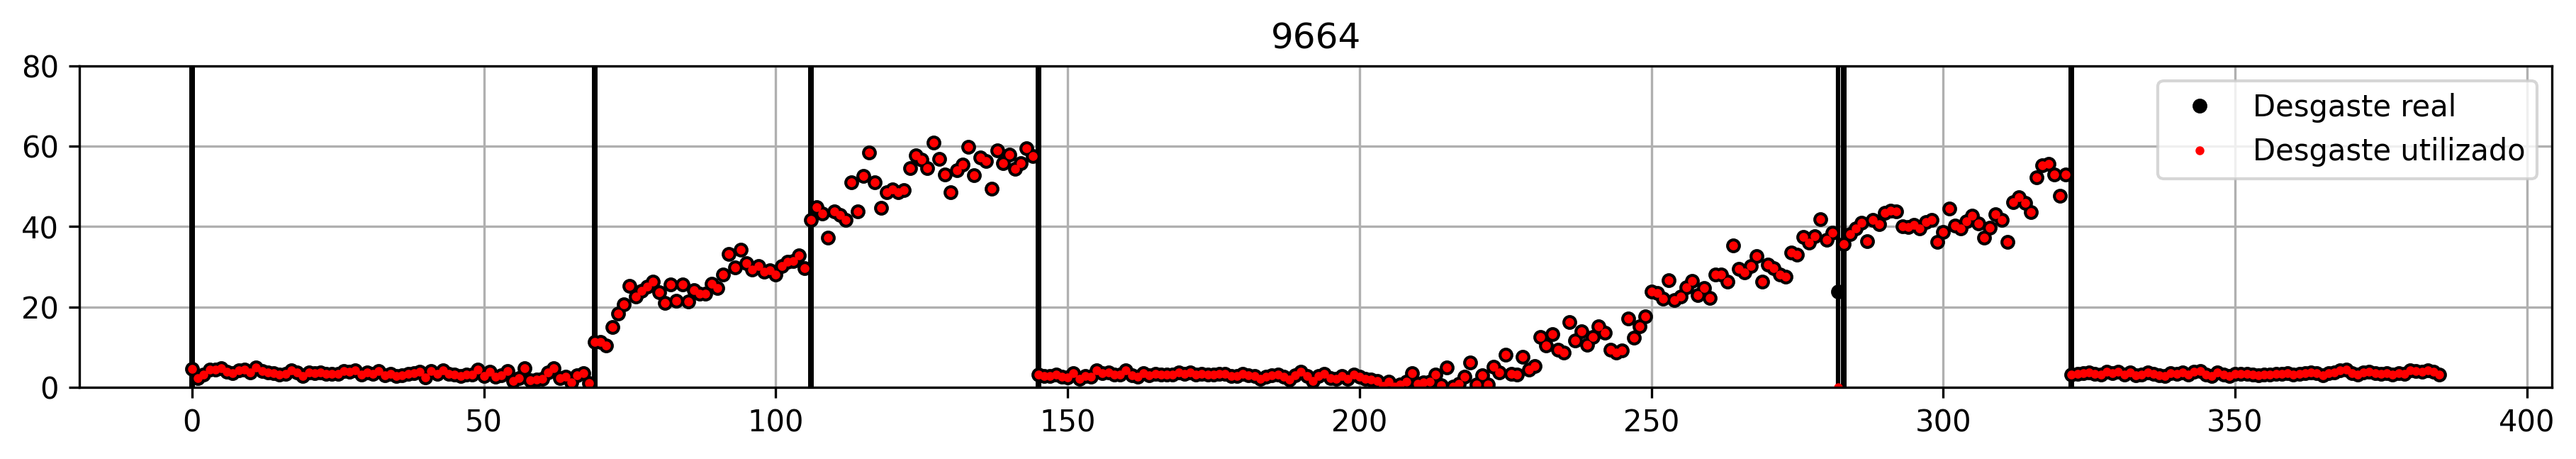

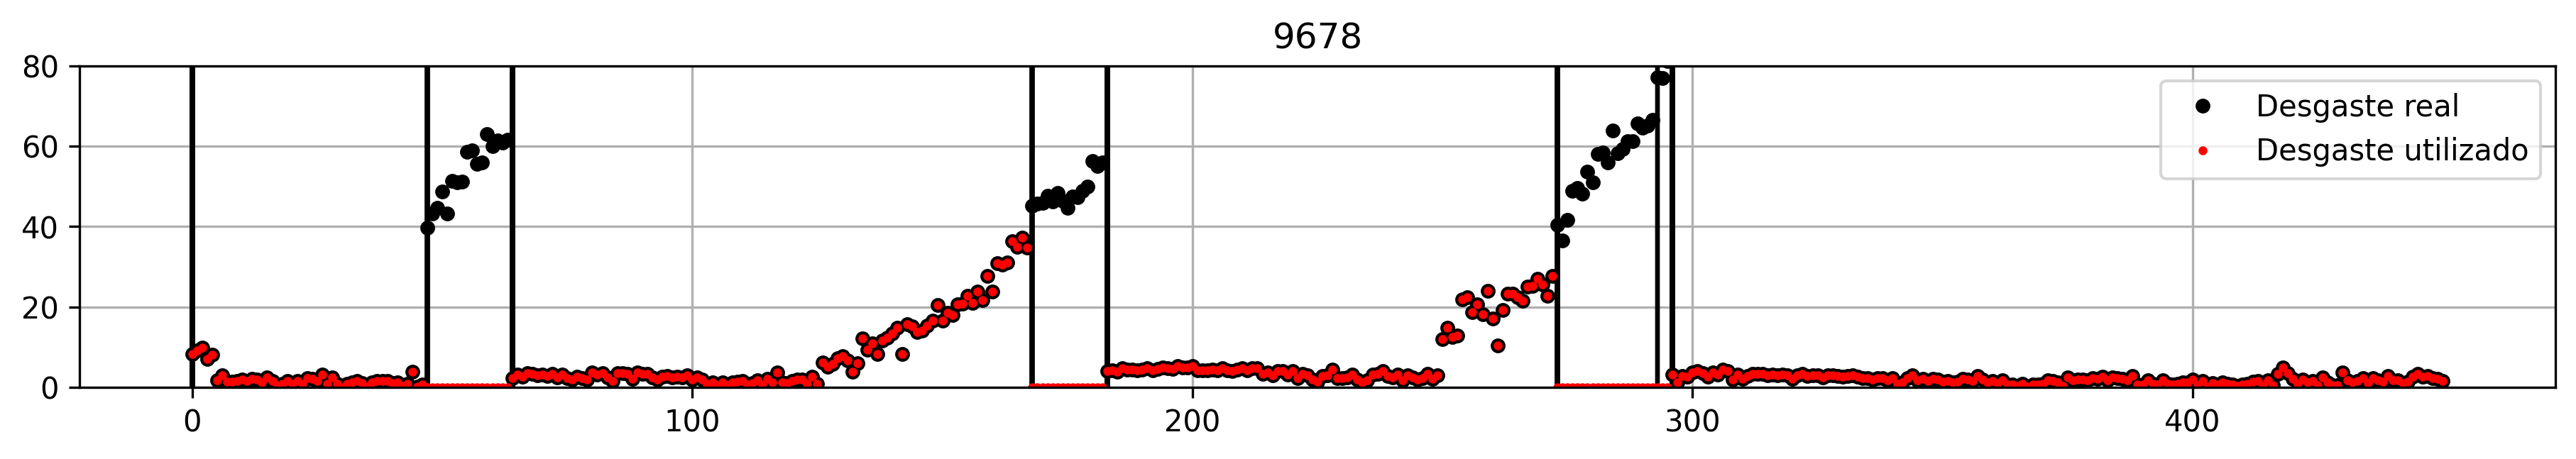

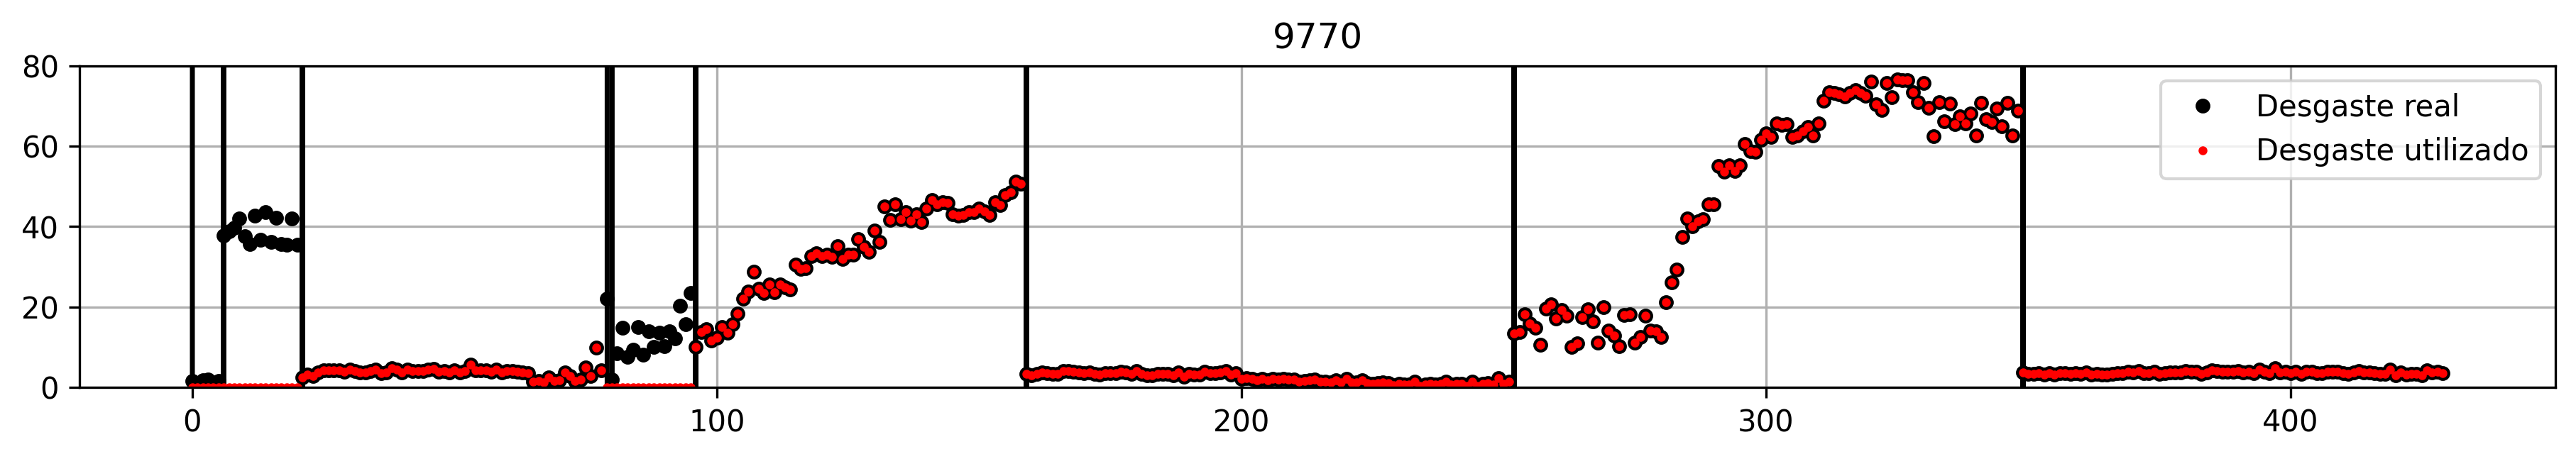

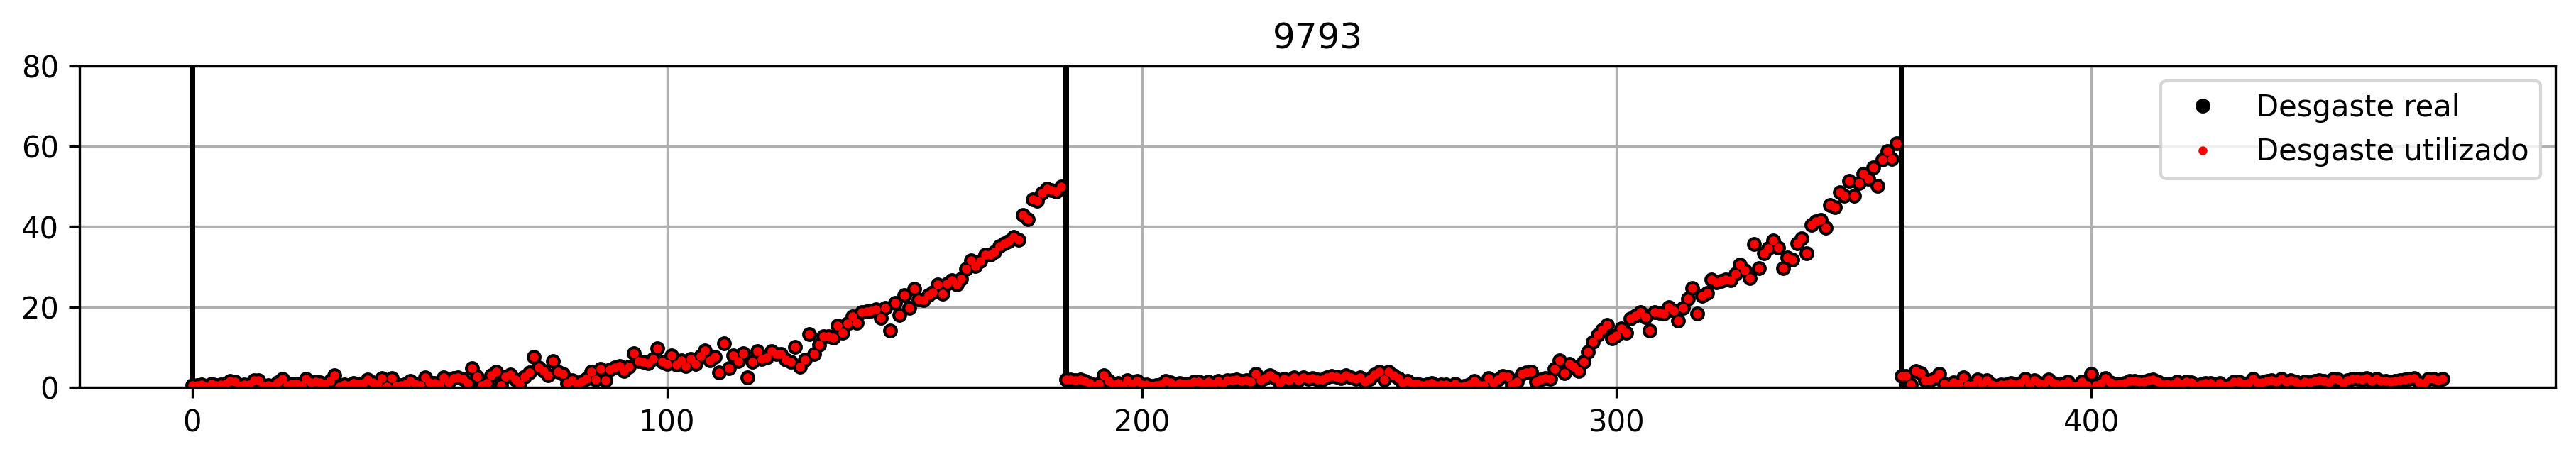

In [132]:
aeronave_test = 1011 #opções: 1011, 9486, 9526, 9636, 9664, 9678, 9770, 9793
cod_falha = 35
aeronaves = np.unique(data.COD_AENV)
look_back=20
train_test (data, aeronave_test,look_back,cod_falha, aim = 'plot')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'RMSE')

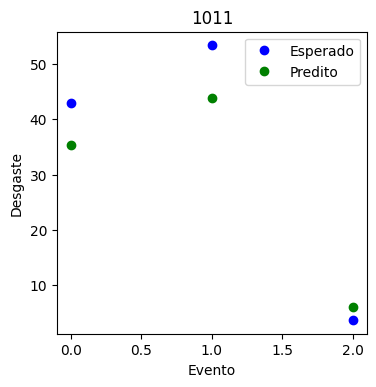

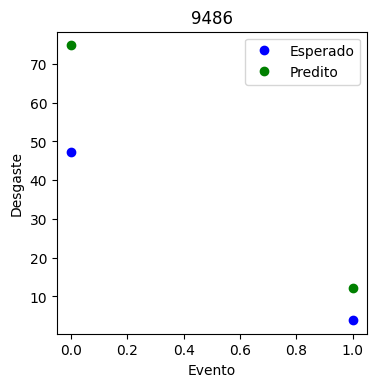

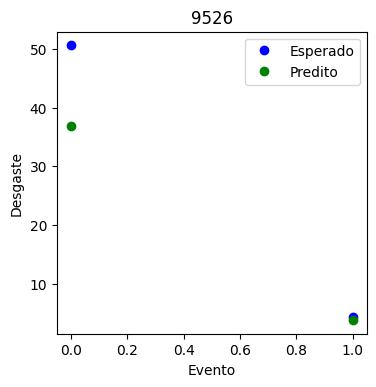

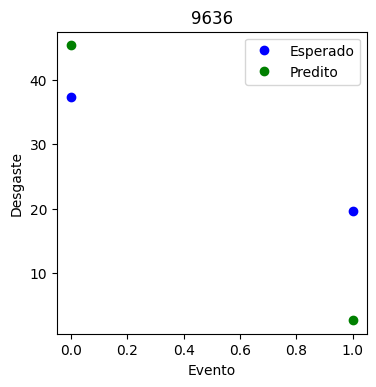

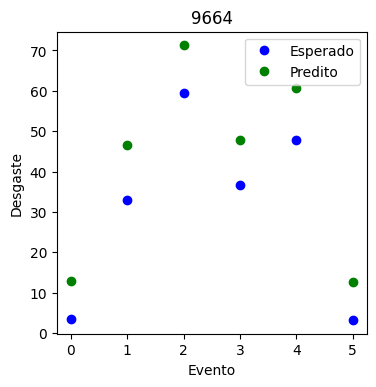

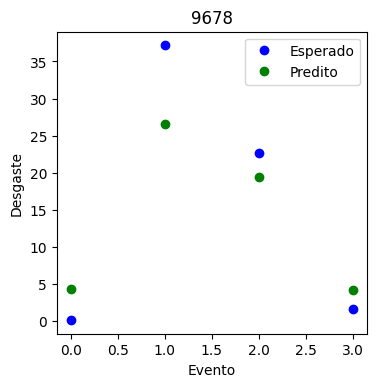

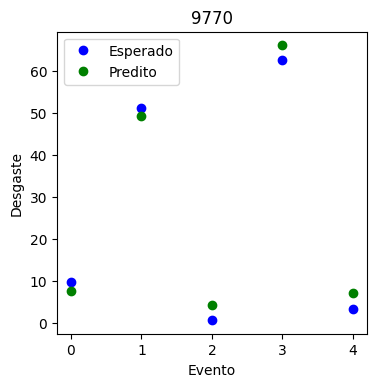

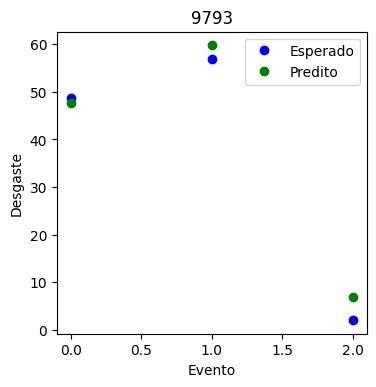

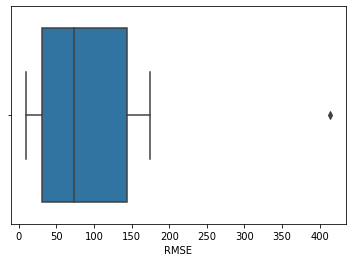

In [ ]:
from sklearn.neural_network import MLPRegressor

rmse = []
for aeronave_test in np.unique(data.COD_AENV):
  MLP = MLPRegressor()
  x_train, y_train, x_test, y_test = train_test(data, aeronave_test,look_back,cod_falha,aim='train_test')
  MLP.fit(x_train,y_train)
  y_pred = MLP.predict(x_test)
  resul_plot(y_test, y_pred,aeronave_test)

  rmse.append(mean_squared_error(y_test*100, y_pred*100,squared=True))
plt.figure()
sns.boxplot(rmse)
plt.xlabel('RMSE')

##Testando filtros

In [134]:
def filtro(desgaste,tipo):
  if tipo == 'media_movel':
    w = 2
    desgaste_filt = np.convolve(desgaste, np.ones(w), 'valid') / w
  
  return desgaste_filt

In [135]:
def quebra_filt(desgaste):
  quebras = []
  desgaste_filt = filtro(desgaste,'media_movel')
  a=0
  for i in range(0,len(desgaste_filt)-1):
    if abs(desgaste_filt[i]-desgaste_filt[i+1])>9:
      if (a == 0):
        a = 1
      else:
        quebras.append(i)   
        a = 0      

  quebras = np.array(quebras)

  return quebras

In [136]:
def desg_uti(desgaste,quebras,look_back):

  des_uti = []
  n_pontos = look_back+10
  a=0
  for i in range(0,len(desgaste)-1):
    if i in quebras:
      if len(desgaste[a:i])>=n_pontos:
        des_uti = des_uti + desgaste[a:i+1].tolist()
      else:
        des_uti = des_uti + len(desgaste[a:i+1])*[-2]
        #print(a)
      a = i+1
  if len(desgaste[a:])>=n_pontos:
    des_uti = des_uti + desgaste[a:].tolist()
  else:
    des_uti = des_uti + len(desgaste[a:])*[-2]

  return des_uti

In [137]:
def descont(data,cod_falha,look_back):

  for aeronave in np.unique(data.COD_AENV):
    aero_data = data[(data.COD_AENV==aeronave)  & (data.COD_FALH==cod_falha)]
    desgaste = aero_data.VLR_DESG.values
    quebra = quebra_filt(desgaste)
    des_uti = desg_uti(desgaste,quebra,look_back)
    func_plot(desgaste,quebra,aeronave,des_uti)

In [138]:
def func_plot (desgaste,quebras,aeronave,des_uti):
  plt.figure(figsize=(15, 2),dpi=300)
  #plt.plot(carac,'xr',label='Carac')
  plt.plot(desgaste,'ok',label='Desgaste real', markersize=4)
  plt.plot(des_uti, 'or',label='Desgaste utilizado', markersize=2)
  plt.legend()
  plt.title(aeronave)
  plt.grid()
  plt.ylim([0,80])
  plt.vlines(quebras, 0, 100)

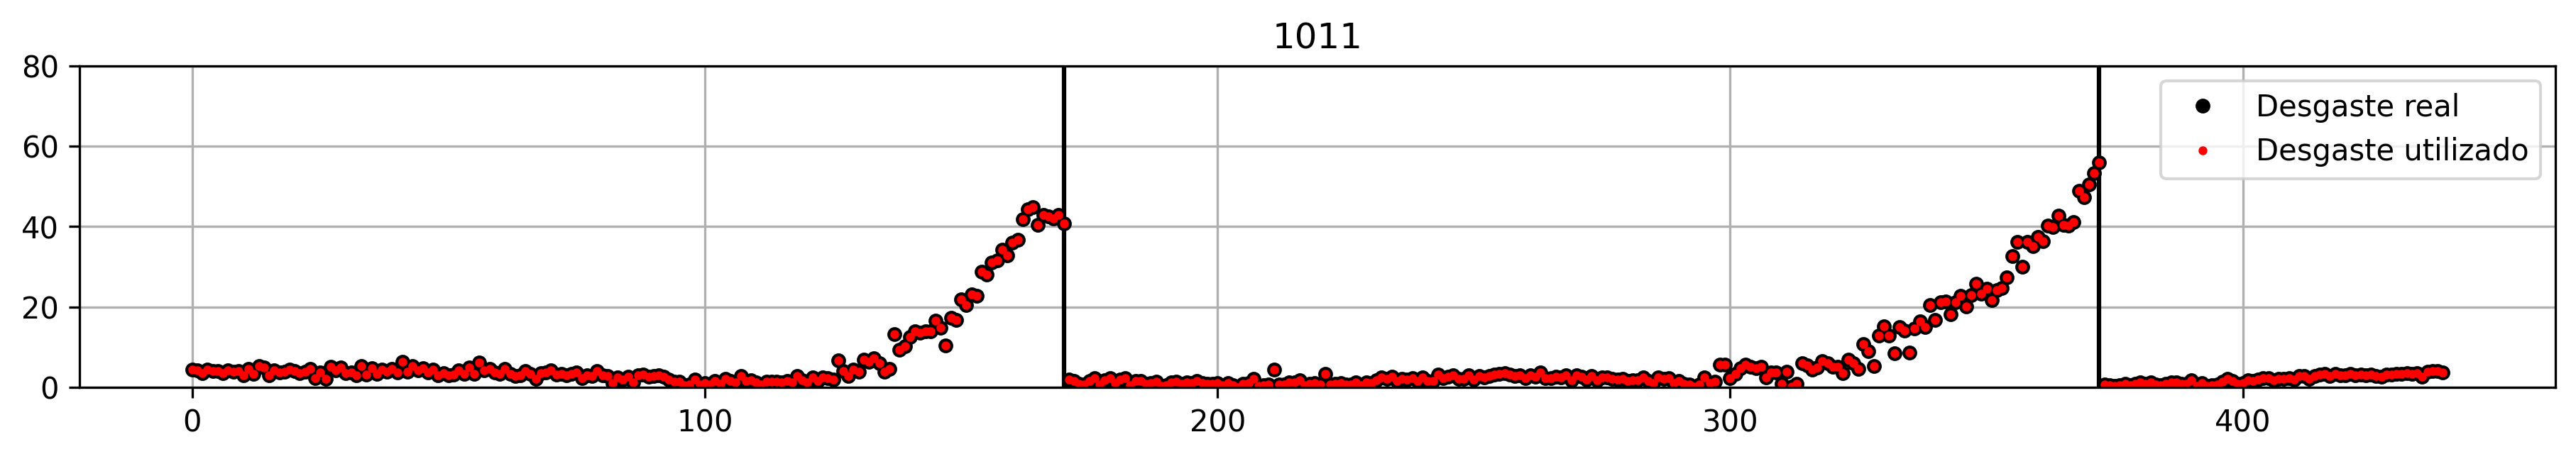

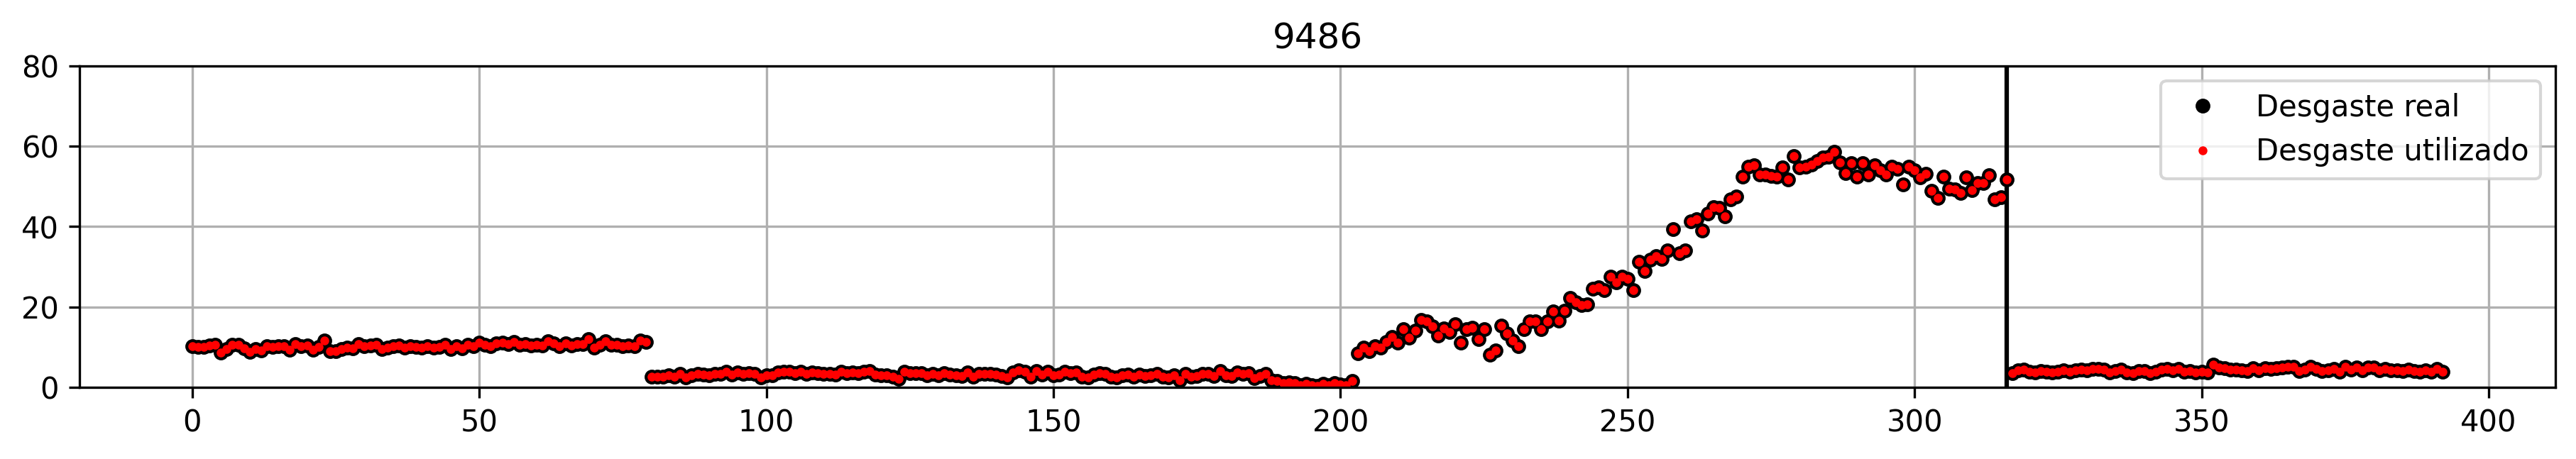

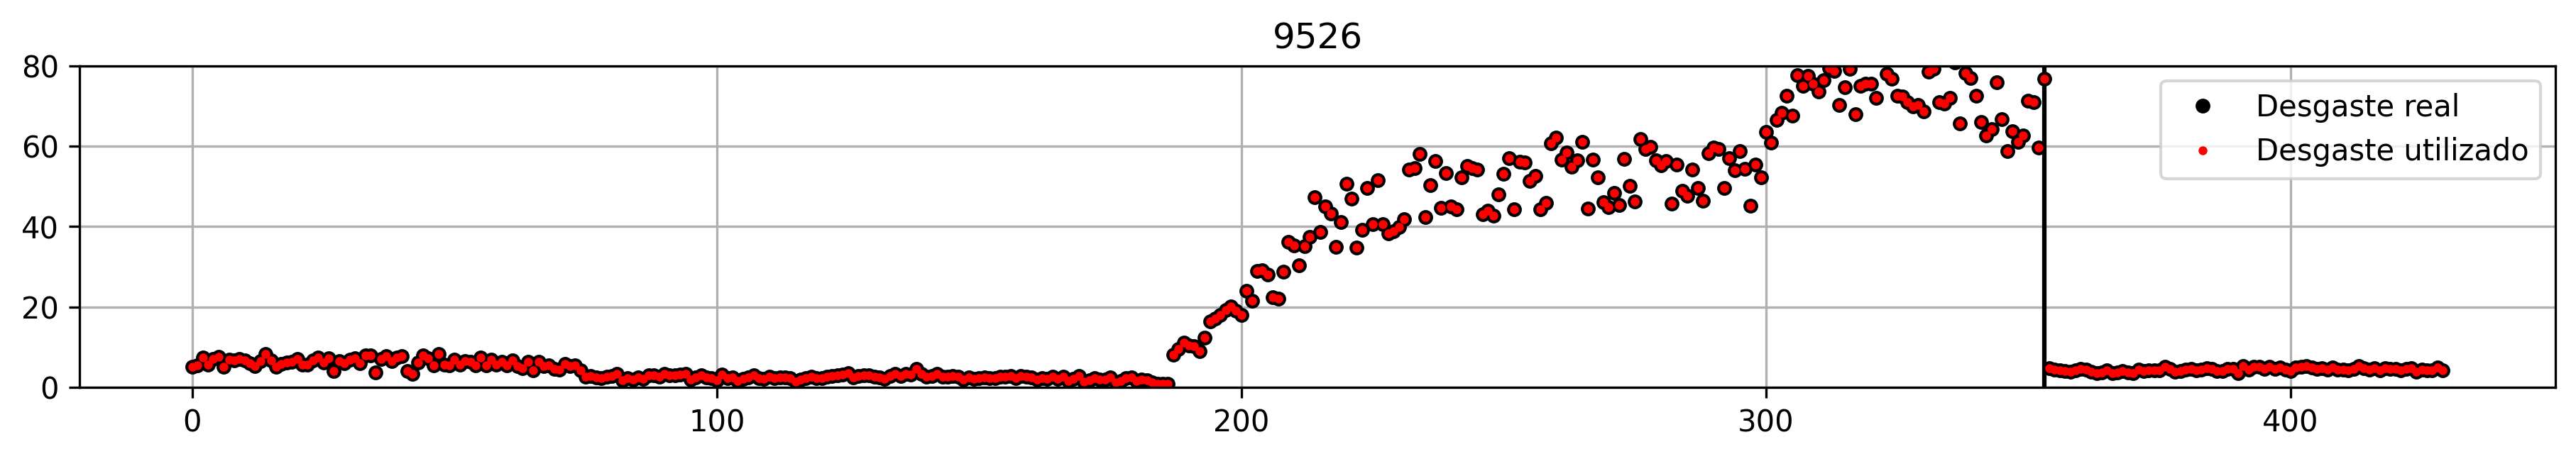

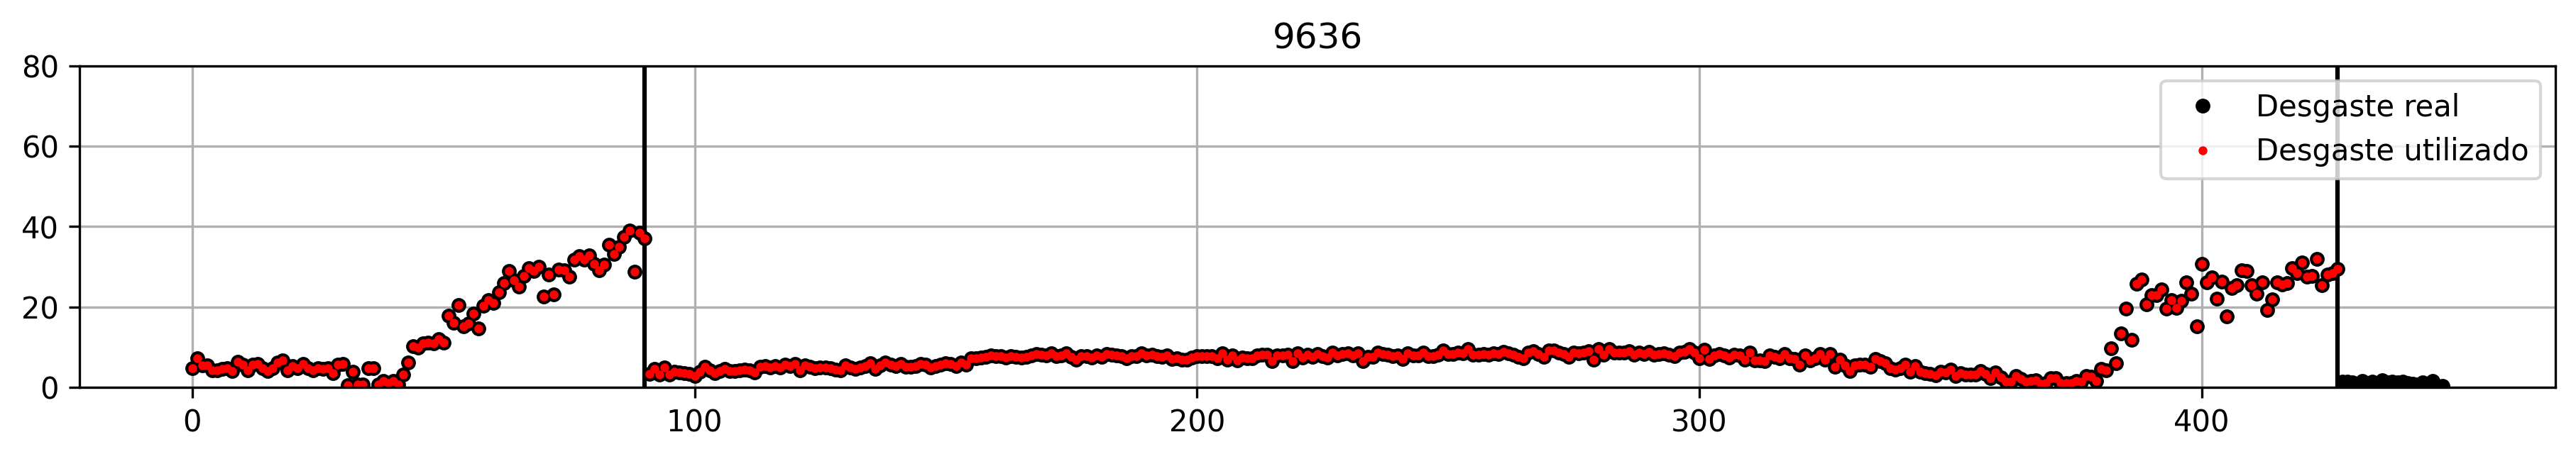

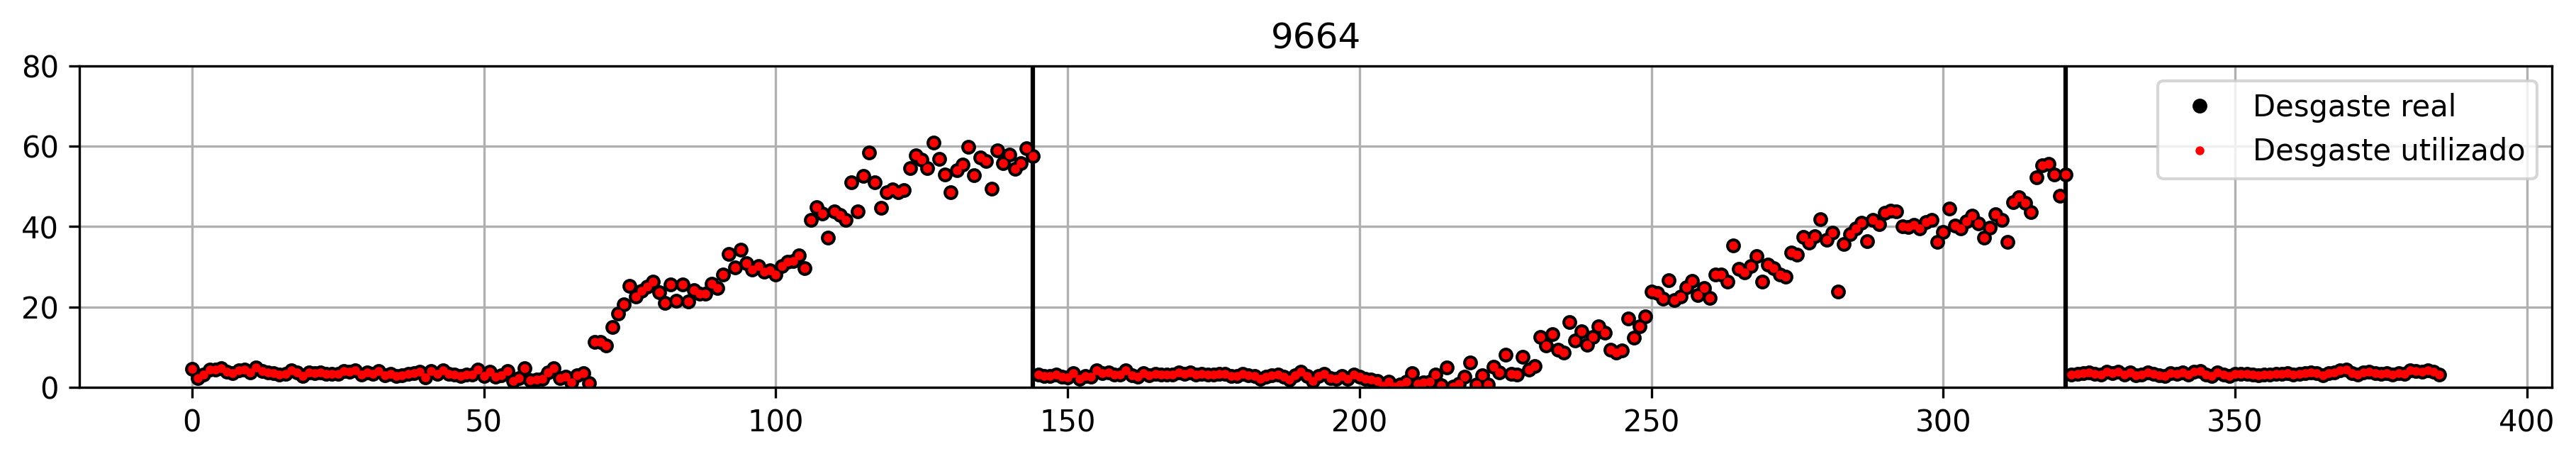

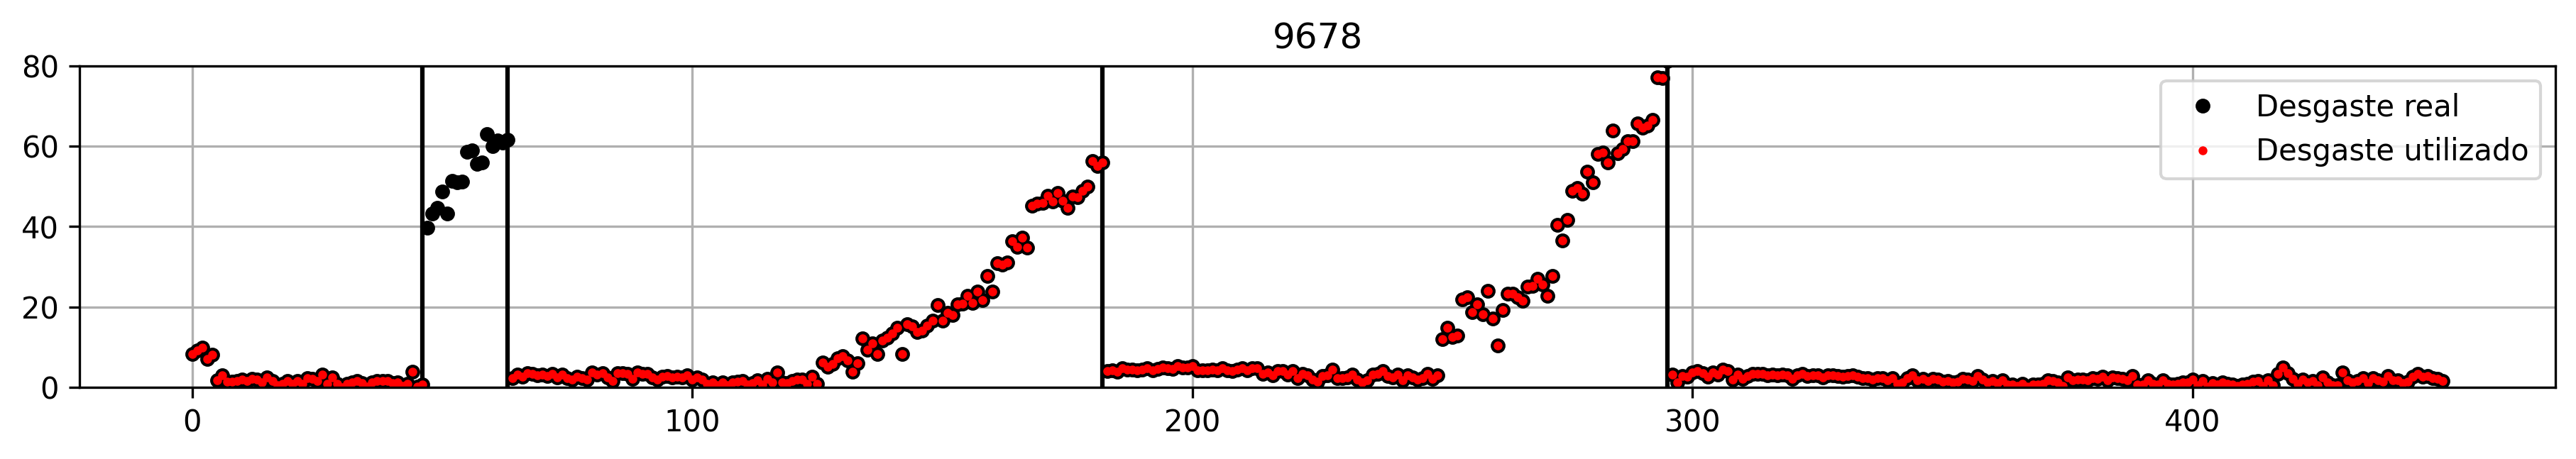

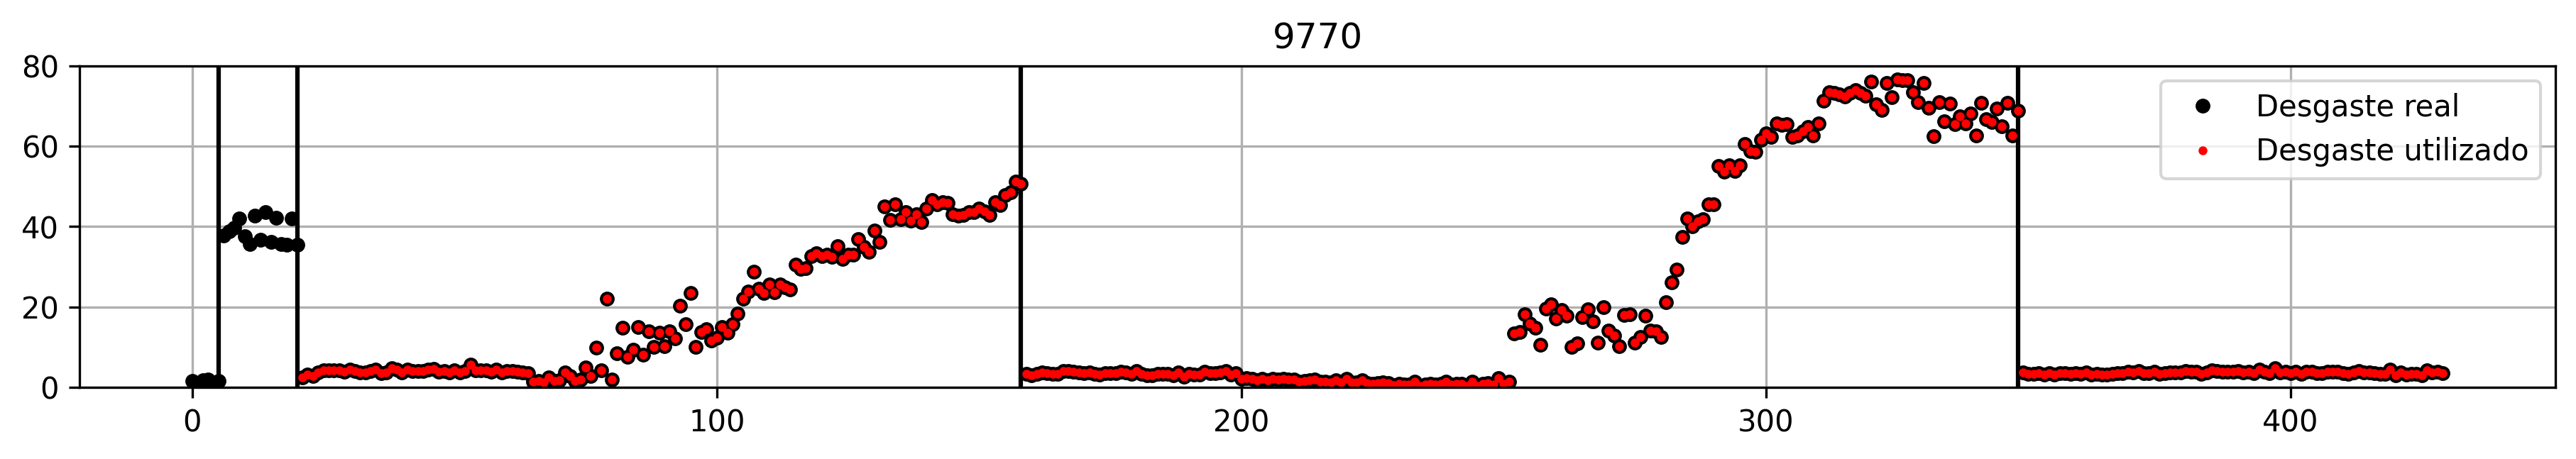

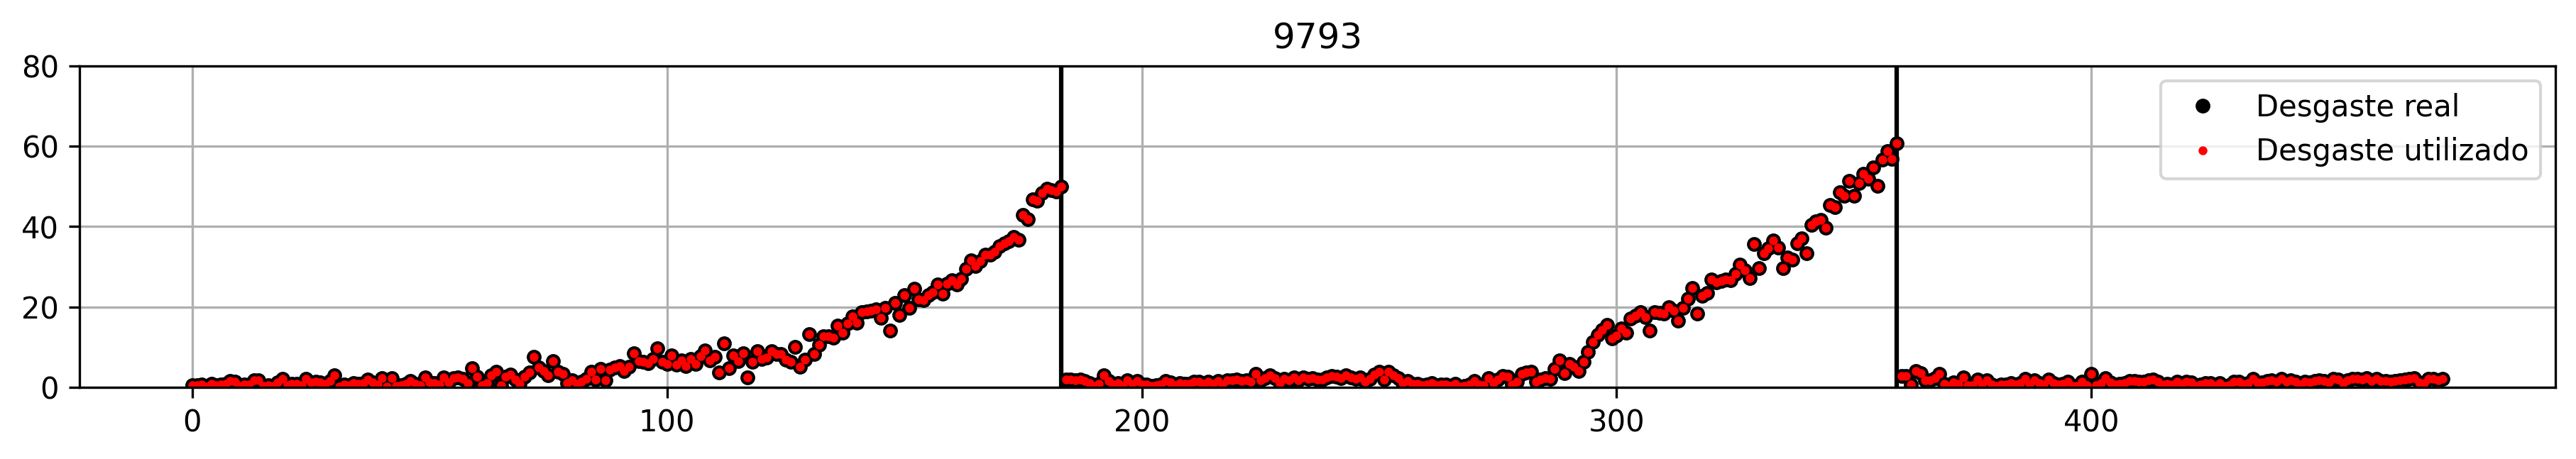

In [139]:
aeronave_test = 1011 #opções: 1011, 9486, 9526, 9636, 9664, 9678, 9770, 9793
cod_falha = 35
aeronaves = np.unique(data.COD_AENV)
look_back=20
descont(data,cod_falha,look_back)

## Testando algumas bibliotecas

### Testando Pro

In [ ]:
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.4 MB/s 
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.7
    Uninstalling cmdstanpy-1.0.7:
      Successfully uninstalled cmdstanpy-1.0.7
    Running setup.py install for fbprophet ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-7fu5d8_0/fbprophet_46a559ca9ce146a88cb49e51e528ea42/setup.py'"'"'; __file__='"'"'/tmp/pip-install-7fu5d8_0/fbprophet_46a559ca9ce146a88cb49e51e528ea42/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.c

In [ ]:
from prophet import Prophet
def fit_predict_model(dataframe, interval_width = 0.7, changepoint_range = 0.7):
   m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
               seasonality_mode = 'additive',
               interval_width = interval_width,
               changepoint_range = changepoint_range)
   m = m.fit(dataframe)
   forecast = m.predict(dataframe)
   forecast['fact'] = dataframe['y'].reset_index(drop = True)
   return forecast


def detect_anomalies(forecast):
   forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
   forecasted['anomaly'] = 0
   forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
   forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
#anomaly importances
   forecasted['importance'] = 0
   forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
       (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
   forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
       (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
  
   return forecasted
  

In [ ]:
def diff_func(t):
  ds = t['ds'].values
  ds = ds[1:]
  y = np.diff(t['y'])
  t_diff = pd.DataFrame({'ds':ds,'y':y})
  return t_diff

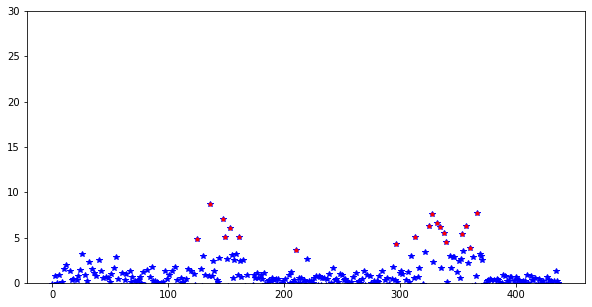

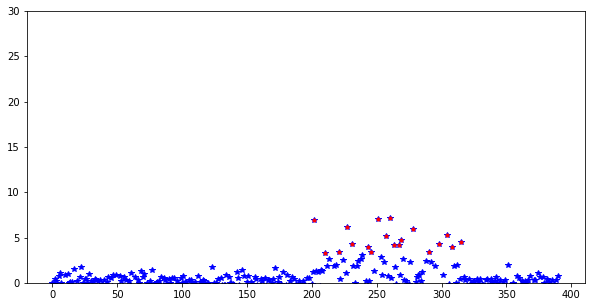

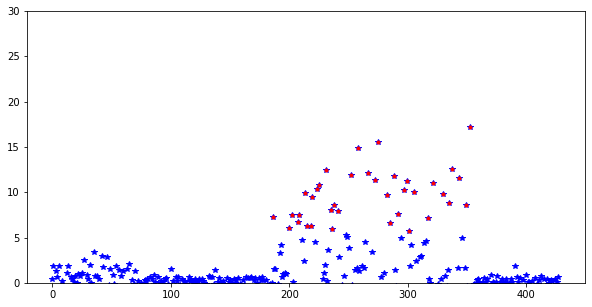

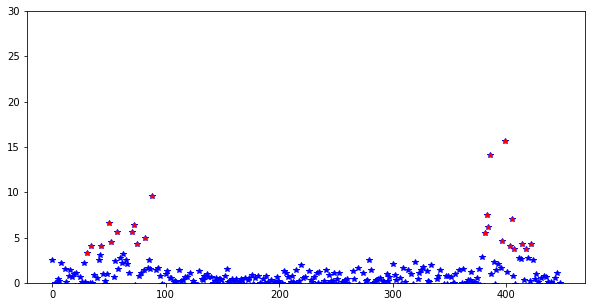

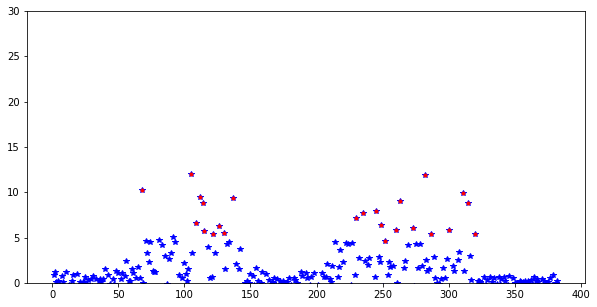

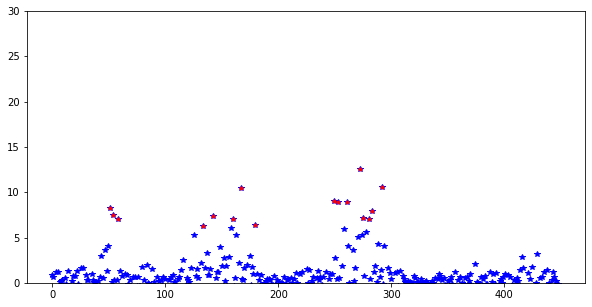

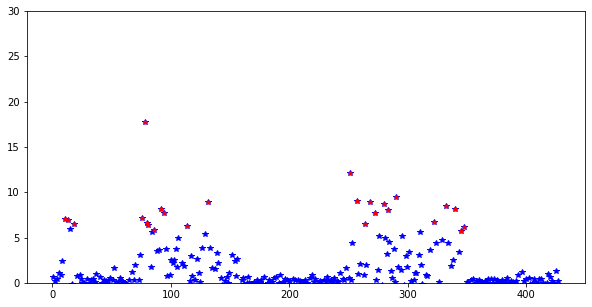

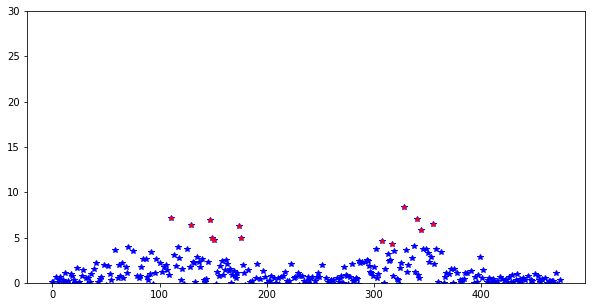

In [ ]:
for aenv in np.unique(data.COD_AENV.values):
  f35_treino = data[(data.COD_AENV==aenv) & (data.COD_FALH==35)]
  t = f35_treino[['DT_PROC','VLR_DESG']].rename(columns={'DT_PROC':"ds",'VLR_DESG':"y"})
  # t = t.sort_values(by ='ds', ascending=False)

  plt.figure(figsize=(10,5))
  #plt.plot(t['y'].values[1:],'o')


  t = diff_func (t)
  pred = fit_predict_model(t)
  pred = detect_anomalies(pred)

  t_ =[]

  for i in range(0,t.shape[0]):
    if pred['anomaly'].values[i]==1:
      t_.append(t['y'].values[i])
    else:
      t_.append(-5)

  plt.plot(t['y'].values, 'b*')
  plt.plot(t_, 'r.')
  # plt.plot(pred['trend'], 'm')	
  plt.ylim([0,30])


In [ ]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,fact
0,2010-01-11,4.975690,-22.867526,31.314527,4.975690,4.975690,0.0,0.0,0.0,0.0,0.0,0.0,4.975690,4.396998
1,2010-01-12,4.980515,-20.970468,33.232282,4.980515,4.980515,0.0,0.0,0.0,0.0,0.0,0.0,4.980515,4.253882
2,2010-01-13,4.985339,-19.497513,32.804208,4.985339,4.985339,0.0,0.0,0.0,0.0,0.0,0.0,4.985339,3.579710
3,2010-01-14,4.990164,-20.702019,30.376578,4.990164,4.990164,0.0,0.0,0.0,0.0,0.0,0.0,4.990164,4.344203
4,2010-01-15,4.994989,-24.819050,31.713053,4.994989,4.994989,0.0,0.0,0.0,0.0,0.0,0.0,4.994989,3.967650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,2012-07-31,9.364303,-18.333488,36.938606,9.364303,9.364303,0.0,0.0,0.0,0.0,0.0,0.0,9.364303,2.550000
436,2012-08-01,9.368709,-17.453306,38.155862,9.368709,9.368709,0.0,0.0,0.0,0.0,0.0,0.0,9.368709,3.827083
437,2012-08-05,9.386333,-15.489672,36.538089,9.386333,9.386333,0.0,0.0,0.0,0.0,0.0,0.0,9.386333,4.046122
438,2012-08-07,9.395144,-20.174568,35.790959,9.395144,9.395144,0.0,0.0,0.0,0.0,0.0,0.0,9.395144,3.985994


In [ ]:
pred

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,2010-01-11,4.975690,4.975690,-22.867526,31.314527,4.396998,0,0.0
1,2010-01-12,4.980515,4.980515,-20.970468,33.232282,4.253882,0,0.0
2,2010-01-13,4.985339,4.985339,-19.497513,32.804208,3.579710,0,0.0
3,2010-01-14,4.990164,4.990164,-20.702019,30.376578,4.344203,0,0.0
4,2010-01-15,4.994989,4.994989,-24.819050,31.713053,3.967650,0,0.0
...,...,...,...,...,...,...,...,...
435,2012-07-31,9.364303,9.364303,-18.333488,36.938606,2.550000,0,0.0
436,2012-08-01,9.368709,9.368709,-17.453306,38.155862,3.827083,0,0.0
437,2012-08-05,9.386333,9.386333,-15.489672,36.538089,4.046122,0,0.0
438,2012-08-07,9.395144,9.395144,-20.174568,35.790959,3.985994,0,0.0


In [ ]:
print(t.shape)
pred.shape

(440, 2)


(440, 8)

(0.0, 100.0)

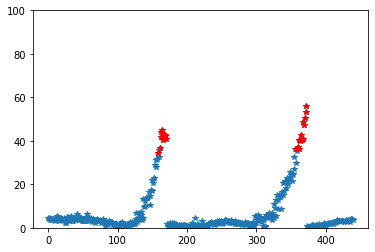

In [ ]:
df = df.sort_values('date_time')
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly1'] == 1, ['date_time', 'price_usd']] #anomaly
ax.plot(pd.to_datetime(df['date_time']), df['price_usd'], color='k',label='Normal')
ax.scatter(pd.to_datetime(a['date_time']),a['price_usd'], color='red', label='Anomaly')
ax.xaxis_date()
plt.xlabel('Date Time')
plt.ylabel('price in USD')
plt.legend()
fig.autofmt_xdate()
plt.show()

#### Testando a biblioteca TSAnalyzer

In [ ]:
!pip install PyQt5
!pip install TSAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.4 MB 14.5 MB/s 
     |████████████████████████████████| 59.9 MB 1.2 MB/s 
     |████████████████████████████████| 344 kB 83.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from TSAnalyzer import *

In [ ]:
import TSAnalyzer.models.offsets as off

In [ ]:
modelo = off.DiscontinuityEvent(data['VLR_CARAC'][0:28])

TypeError: ignored

In [ ]:
data.columns

Index(['COD_FALH', 'COD_AENV', 'COD_EVNT', 'COD_CARAC_NOM', 'VLR_CARAC',
       'DT_PROC', 'VLR_DESG', 'id'],
      dtype='object')

In [ ]:
a=modelo.getFunctionAndParameters(np.arange('2005-02', '2005-03', dtype='datetime64[D]'))

AttributeError: ignored

In [ ]:
print(a)

Simple jump event


In [ ]:
arr  = np.array( [0]*15 + [10]*13)